<a href="https://colab.research.google.com/github/Svetlana-L/Tools-for-Data-Science-IBM/blob/main/Nn_sber_summer_school.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ссылка на этот Колаб: https://colab.research.google.com/drive/1ffUo8jgc5A3nBptsN1ysA1UsyOmDWFGa?usp=sharing


# Импортируем библиотеки

In [ ]:
import glob
import os
import requests
import time
import warnings

warnings.simplefilter('ignore', FutureWarning)

from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# sns.set_style(style='whitegrid')
device_num = 0
torch.cuda.set_device(device_num)


device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda:0'

# Код для обучения

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, 
                                    kernel_size=5, stride=2, padding=2))

from torchsummary import summary

summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           4,864
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 6.12
Params size (MB): 0.02
Estimated Total Size (MB): 6.72
----------------------------------------------------------------


In [ ]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()


def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history    

#  CIFAR10

Датасет состоит из 60k картинок 32х32х3. 

50k - обучающая выборка, 10k - тестовая. 

10 классов: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

 ![](https://sun9-72.userapi.com/c857216/v857216523/12dbca/vdSCet5LS_0.jpg)

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)
# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [40000, 10000]
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''

        super(MySimpleModel, self).__init__()
        # входное количество признаков = высота * ширина * кол-во каналов картинки
        # сейчас 64 нейрона в первом слое
        self.linear1 = nn.Linear(3 * 32 * 32, 64)
        # 10 нейронов во втором слое
        self.linear2 = nn.Linear(64, 10)  # логиты (logits) для 10 классов
        
    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        return x

Epoch 10 of 10 took 6.463s
  training loss (in-iteration): 	1.615483
  validation loss (in-iteration): 	1.643879
  training accuracy: 			43.21 %
  validation accuracy: 			42.44 %


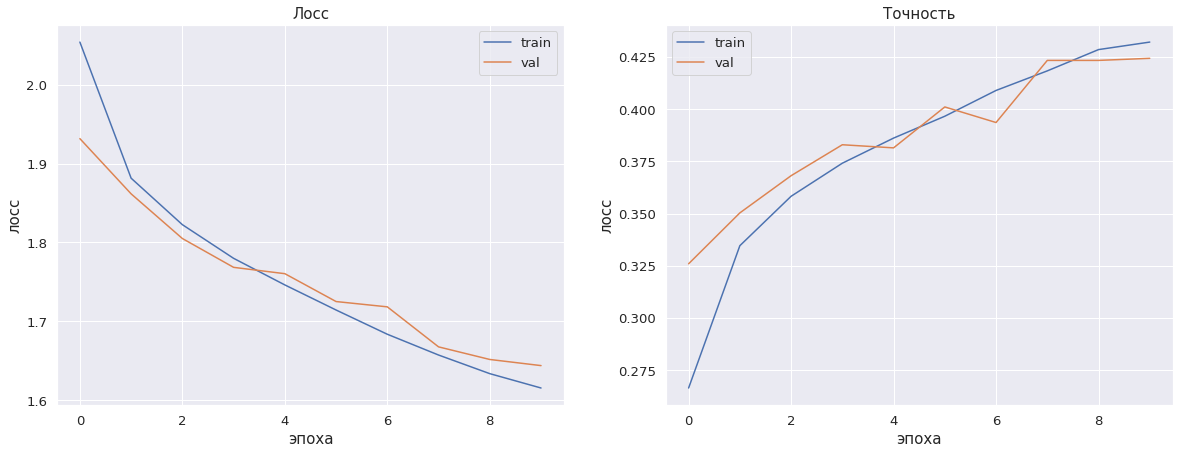

In [ ]:
model = MySimpleModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

# Сверточная нейросеть

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(3, 2048, kernel_size=5, stride=2, padding=3))
model.add_module('mp1', nn.MaxPool2d(7))
model.add_module('conv2', nn.Conv2d(2048, 64, kernel_size=3))
model.add_module('mp2', nn.MaxPool2d(2))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('dp1', nn.Dropout(0.5))
model.add_module('relu1', nn.ReLU())

model.add_module('conv3', nn.Conv2d(64, 128, kernel_size=(20, 20)))
model.add_module('mp3', nn.MaxPool2d(2))
model.add_module('conv4', nn.Conv2d(128, 256, kernel_size=(20, 20)))

model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(1024, 512))
model.add_module('fc2', nn.Linear(512, 10))
model.add_module('dp2', nn.Dropout(0.05))

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

RuntimeError: ignored

## Хороший вариант

In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        model = nn.Sequential()
        # Блок 1: Свёртка с большим ядром, чтобы уловить общие закономерности
        model.add_module(
            'conv1', 
            nn.Conv2d(
                3, 16, 
                kernel_size=5,  
                padding=2
            )
        )
        # Важно! Батч-нормализация всегда идёт до функции активации!
        model.add_module('bn1', nn.BatchNorm2d(16))
        model.add_module('mp1', nn.MaxPool2d(2))
        model.add_module('dp1', nn.Dropout(0.2))

        # Блок 2: Свёртка с ядром поменьше, выделяет более тонкие признаки.
        model.add_module('conv2', nn.Conv2d(16, 32, kernel_size=3, padding=1))
        model.add_module('bn2', nn.BatchNorm2d(32))
        model.add_module('mp2', nn.MaxPool2d(2))
        # Важно! Дропаут идёт после функции активации!
        model.add_module('dp2', nn.Dropout(0.2))

        # Блок 3: Линейный слой поверх карт активации
        model.add_module('flatten', nn.Flatten())
        model.add_module('fc1', nn.Linear(2048, 512))
        model.add_module('bn3', nn.BatchNorm1d(512))
        model.add_module('relu1', nn.ReLU())
        model.add_module('dp3', nn.Dropout(0.2))

        # Блок 4: Классификационный слой
        model.add_module('fc2', nn.Linear(512, 10))
        self.model = model

    def forward(self, x):
        return self.model(x)

# Обучение сверточной нейросети

Epoch 10 of 10 took 7.831s
  training loss (in-iteration): 	0.925832
  validation loss (in-iteration): 	1.318069
  training accuracy: 			67.94 %
  validation accuracy: 			55.68 %


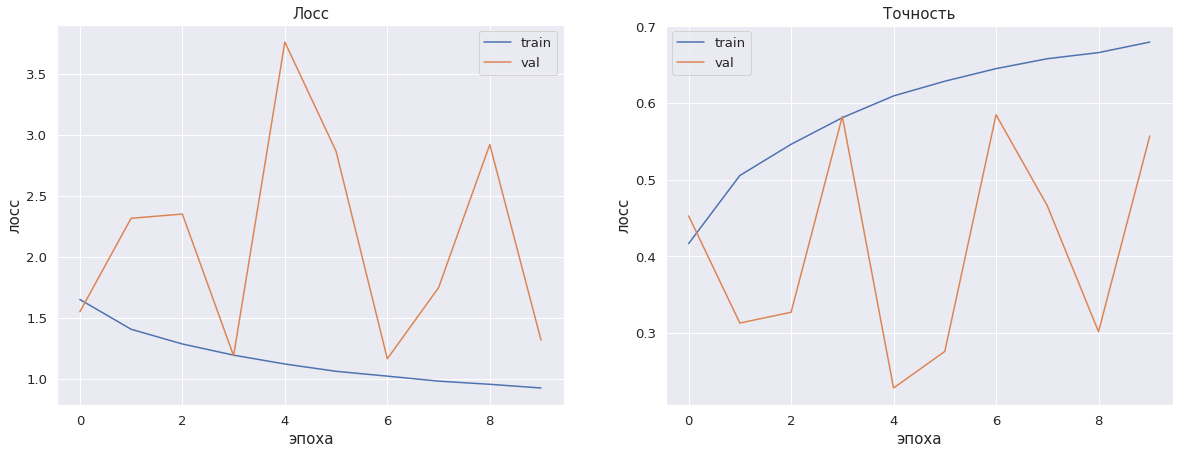

In [ ]:
model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

# Pose Estimation

## Установка и импорты

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 96.2 MB/s 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving afe276e0fe5e25198086c0a5899312e105f2f603_1186_662.jpg to afe276e0fe5e25198086c0a5899312e105f2f603_1186_662.jpg


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}

afe276e0fe5e25198086c0a5899312e105f2f603_1186_662.jpg


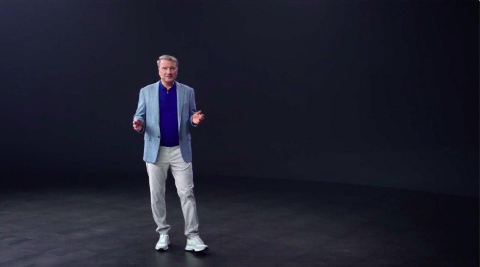

In [ ]:
for name, image in images.items():
  print(name)   
  resize_and_show(image)

## Пример работы

In [ ]:
import torchvision

In [ ]:
model = torchvision.models.resnet50()

$\int_0^9$

In [ ]:
import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles


Pose landmarks of afe276e0fe5e25198086c0a5899312e105f2f603_1186_662.jpg:


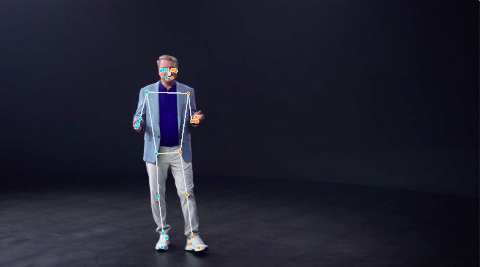

In [ ]:
# Run MediaPipe Pose and draw pose landmarks.
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Print nose landmark.
    image_hight, image_width, _ = image.shape
    if not results.pose_landmarks:
      continue

    # Draw pose landmarks.
    print(f'Pose landmarks of {name}:')
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    resize_and_show(annotated_image)

Nose world landmark:
x: 0.005070068407803774
y: -0.5950801372528076
z: -0.2849676012992859
visibility: 0.9999136924743652



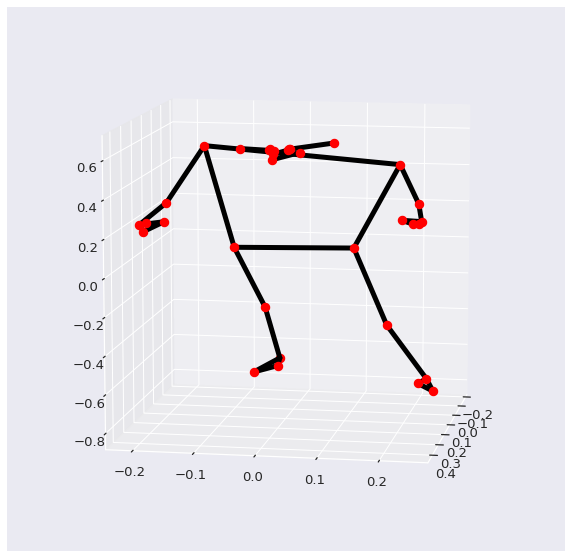

In [ ]:
# Run MediaPipe Pose and plot 3d pose world landmarks.
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
  for name, image in images.items():
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print the real-world 3D coordinates of nose in meters with the origin at
    # the center between hips.
    print('Nose world landmark:'),
    print(results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.NOSE])
    
    # Plot pose world landmarks.
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

Pose segmentation of afe276e0fe5e25198086c0a5899312e105f2f603_1186_662.jpg:


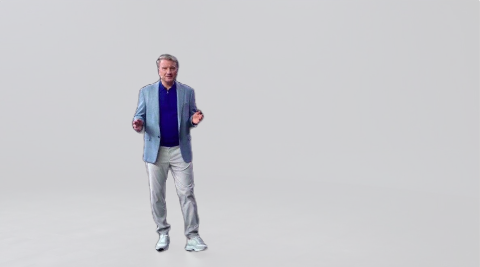

In [ ]:
# Run MediaPipe Pose with `enable_segmentation=True` to get pose segmentation.
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, 
    model_complexity=2, enable_segmentation=True) as pose:
  for name, image in images.items():
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw pose segmentation.
    print(f'Pose segmentation of {name}:')
    annotated_image = image.copy()
    red_img = np.zeros_like(annotated_image, dtype=np.uint8)
    red_img[:, :] = (255,255,255)
    segm_2class = 0.2 + 0.8 * results.segmentation_mask
    segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
    annotated_image = annotated_image * segm_2class + red_img * (1 - segm_2class)
    resize_and_show(annotated_image)

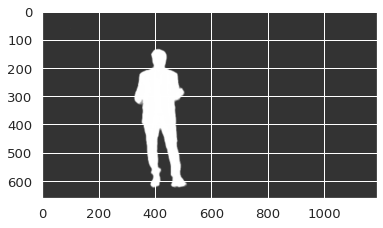

In [ ]:
plt.imshow(segm_2class)

# NLP -- Netflix description generation

## Библиотеки

In [ ]:
!git clone https://github.com/dredwardhyde/gpt-neo-fine-tuning-example

Cloning into 'gpt-neo-fine-tuning-example'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 124 (delta 72), reused 74 (delta 31), pack-reused 0
Receiving objects: 100% (124/124), 2.28 MiB | 4.87 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 26.5 MB/s 
     |████████████████████████████████| 596 kB 58.7 MB/s 
     |████████████████████████████████| 6.6 MB 54.5 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## GPT2 

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel


backbone = 'gpt2'

torch.manual_seed(42)
tokenizer = GPT2Tokenizer.from_pretrained(backbone, bos_token='<|endoftext|>',
                                          eos_token='<|endoftext|>', pad_token='<|pad|>')
model = GPT2LMHeadModel.from_pretrained(backbone).cuda()

model.resize_token_embeddings(len(tokenizer))



Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Embedding(50258, 768)

In [ ]:
descriptions = pd.read_csv('/content/gpt-neo-fine-tuning-example/netflix_titles.csv')['description']
max_length = max([len(tokenizer.encode(description)) for description in descriptions])

In [ ]:
descriptions[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

In [ ]:
class NetflixDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for txt in txt_list:
            encodings_dict = tokenizer('<|endoftext|>' + txt + '<|endoftext|>', truncation=True,
                                       max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


dataset = NetflixDataset(descriptions, tokenizer, max_length=max_length)




train_size = int(0.9 * len(dataset))



train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

training_args = TrainingArguments(output_dir='./results', num_train_epochs=5, logging_steps=500, save_steps=5000,
                                  per_device_train_batch_size=2, per_device_eval_batch_size=2,
                                  warmup_steps=100, weight_decay=0.01, logging_dir='./logs')


Trainer(model=model, args=training_args, train_dataset=train_dataset,
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()


***** Running training *****
  Num examples = 7008
  Num Epochs = 5
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 17520


Step,Training Loss
500,4.679200
1000,1.931100
1500,1.930000
2000,1.913900
2500,1.866500
3000,1.883100
3500,1.862200
4000,1.606700
4500,1.608900
5000,1.600200


Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-10000
Configuration saved in ./results/checkpoint-10000/config.json
Model weights saved in ./results/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-15000
Configuration saved in ./results/checkpoint-15000/config.json
Model weights saved in ./results/checkpoint-15000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=17520, training_loss=1.5588257270316555, metrics={'train_runtime': 1786.5329, 'train_samples_per_second': 19.613, 'train_steps_per_second': 9.807, 'total_flos': 1108694753280000.0, 'train_loss': 1.5588257270316555, 'epoch': 5.0})

In [ ]:
starts = 'Squid game is'#@param{type:'string'}

generated = tokenizer("<|endoftext|>" + starts , return_tensors="pt").input_ids.cuda()

sample_outputs = model.generate(generated, do_sample=True, top_k=50,
                                max_length=300, top_p=0.95, temperature=1.9, num_return_sequences=20)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Squid game is back for everyone. If you play as a team whose fate – and skills – prevent disaster from coming true, you have 24 Hours' worth of strategy.
1: Squid game is on! Ready-handed cop Chien finds himself caught up in the fierce online combat genre cat-riot, and must team up himself to defend high school leopard.
2: Squid game is called for players when they make five attempts toward the record keeping champion in five rounds, then play as the game's Final Boss. Three people in total. Meet "Spry Team!" in Cartoon "Grimm City."
3: Squid game is back, and buddy X is back to help Rocky face his friends in court, with help finding out if you belong on the planet C-Su.
4: Squid game is sprung when Lucky learns how to dance the "Candy Cookie" squares, becoming a member of the legendary Crystal Empire.
5: Squid game is back as Squid was a sluery breed: Count De Mars, Bumblebee Tooth Twister and Lucky Gluck fly around your bedroom and bump you up in exciting ways.
6: Squid game is ri

In [ ]:
starts = 'Avengers released as'#@param{type:'string'}

generated = tokenizer("<|endoftext|>" + starts , return_tensors="pt").input_ids.cuda()

sample_outputs = model.generate(generated, do_sample=True, top_k=50,
                                max_length=300, top_p=0.95, temperature=1.9, num_return_sequences=20)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Avengers released as involuntary involuntary prisoners cross the Hollywood fence at camp on the anniversary in this visually arresting true tale.
1: Avengers released as part of an undercover mission risk losing Hollywood forever after realizing the world isn't the best it can be. As they learn to fly – they defeat Captain Bat-jumper.
2: Avengers released as supersurface steal pay a million bahlings at destiny upon the Avengers, with help from Ant-Man and Captain America and V.C. Draven. Tasko joins them. A New York Comic Con panel featuring Marvel and BBC Radio.
3: Avengers released as limited-time downloads turn a hit metal comic on with his take on aging super villains Black ops, super-powered mutants and green power armor.
4: Avengers released as Decepticons and sent back as Guardians against evil Than Megathron once led an army in battle against the Nova Deities. Avengers, Thanos, Thanos now lives in Metapanda.
5: Avengers released as sloth before spring reawakens X'Lehn and Ze